# Regrid LDEO climatology to 1x1

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe

## Regrid LDEO

In [2]:
# Load raw takahashi
ds = xr.open_dataset(f'/local/data/artemis/workspace/gloege/data/LDEO/TALK_TCO2_pCO2_GLOB_Grid_Dat.nc')

# Select pco2
ds = ds['pco2_wat_sst']

# Output grid
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90, 1.0)),
                     'lon': (['lon'], np.arange(-179.5, 180, 1.0)),
                    })

# Define the re-gridder
#regridder = xe.Regridder(ds, ds_out, 'bilinear')
regridder = xe.Regridder(ds, ds_out, 'nearest_s2d')
regridder  # print basic regridder information.

# Regrid the output
ds_out = regridder(ds)

Overwrite existing file: nearest_s2d_40x72_180x360.nc 
 You can set reuse_weights=True to save computing time.


## Plot original

/home/gloege/miniconda3/envs/xesmf/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


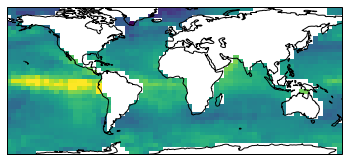

In [3]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.pcolor(ds['lon'], ds['lat'], ds.mean('time'), vmin=280, vmax=440)
ax.coastlines()

## Plot regridded
`nearest_s2d` effectively cuts each grid cell into 4 boxes. the `bilinear` scheme makes a smoother product, but becomes more coarse. For this reason, I chose `nearest_s2d`

In [4]:
# LDEO database goes to 80N
# The grid I use goes to the pole. 
# this line makes sure stuff near the pole is NaN
ds_out = ds_out.where(ds_out>0)

### Plot regridded

/home/gloege/miniconda3/envs/xesmf/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


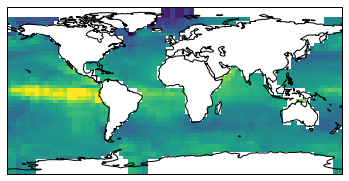

In [5]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.pcolor(ds_out['lon'], ds_out['lat'], ds_out.mean('time'), vmin=280, vmax=440)
ax.coastlines()

# Apply land sea mask

In [16]:
# Observations directory
dir_obs = '/local/data/artemis/observations'

# land-sea mask
# land=0, sea=1
ds_mask = xr.open_dataset(f'{dir_obs}/masks/originals/lsmask.nc').sortby('lat').squeeze().drop('time')

In [14]:
# Put into xarray dataset
ds_out2 = xr.Dataset(
    {
    'spco2':(['time', 'lat', 'lon'], ds_out.roll(lon=180, roll_coords='lon'),
            {'long_name':'CO2 partial pressure at SST estimated for year 2005',
             'units':'microatm'}),
    },

    coords={
    'time': (['time'], ds_out['time']),
    'lat': (['lat'], ds_out['lat'],  {'long_name':'latitude', 'units':'degN'}),
    'lon': (['lon'], np.arange(0.5, 360, 1), {'long_name':'longitude', 'units':'degE'}),
    },
    attrs={'contact':'Luke Gloege',
          'email':'gloege@ldeo.columbia.edu',
          'creation_date':'25 September 2019',
          'regrid':'regridded to 1x1 from native 4x4 grid using xesmf nearest_s2d method'})

In [17]:
# Trim time
ds_masked= ds_out2.where(ds_mask['mask']==1)

In [24]:
# Add attribute about masking
ds_masked.attrs['masking'] = 'masked with NOAA land-sea mask'

In [25]:
# display information
ds_masked.info()

xarray.Dataset {
dimensions:
	lat = 180 ;
	lon = 360 ;
	time = 12 ;

variables:
	float64 spco2(time, lat, lon) ;
		spco2:long_name = CO2 partial pressure at SST estimated for year 2005 ;
		spco2:units = microatm ;
	datetime64[ns] time(time) ;
	float64 lat(lat) ;
		lat:long_name = latitude ;
		lat:units = degN ;
	float64 lon(lon) ;
		lon:long_name = longitude ;
		lon:units = degE ;

// global attributes:
	:contact = Luke Gloege ;
	:email = gloege@ldeo.columbia.edu ;
	:creation_date = 25 September 2019 ;
	:regrid = regridded to 1x1 from native 4x4 grid using xesmf nearest_s2d method ;
	:masking = masked with NOAA land-sea mask ;
}

## Plot masked data

/home/gloege/miniconda3/envs/xesmf/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


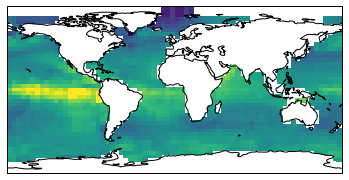

In [20]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.pcolor(ds_masked['lon'], ds_masked['lat'], ds_masked['spco2'].mean('time'), vmin=280, vmax=440)
ax.coastlines()

## Save as NetCDF

In [26]:
ds_masked.to_netcdf('/local/data/artemis/observations/LDEO_database/processed/spco2_1x1_mon_LDEO_clim.nc')